<h1> Satellite Precipitation Data Analysis</h1>

<p> This project's goal is to analyze PERSIANN (Precipitation Estimation from Remotely Sensed Information using Artificial Neural Networks) 
dataset provided by CHRS Data Portal. </p>

In [4]:
## Data domain

## NCOLS and NROWS are the number of columns and rows in the raster defined by the ASCII file
N_COLS = 42
N_ROWS = 25

## XLLCORNER and YLLCORNER are the coordinates of the lower left corner of the lower left cell
XLL_CORNER = 14.000
YLL_CORNER = 49.000

## CELLSIZE is the cell size of the raster.
CELL_SIZE = 0.25

NO_DATA_VALUE = -99
UNIT = "mm"

<h2>Exploring the data</h2>

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
example_satellite_image_path = "./data/PERSIANN_6h2019011706.tif"

example_img = np.asarray(Image.open(example_satellite_image_path))
print("Data (tiff image) shape:", example_img.shape)

Data (tiff image) shape: (25, 42)


In [6]:
print("Data as array (row nr 10):", example_img[10])

Data as array (row nr 10): [-99.   -99.     0.     0.     0.     0.38   0.36   0.35   0.36   0.36
   0.63   0.36   0.8    0.59   0.8    0.78   0.25   0.25   0.     0.
   0.     0.     0.     0.     0.     0.     0.24   0.22   0.21   1.23
   1.02   0.81   1.35   1.64   1.56   1.26   0.81   0.56   0.75 -99.
 -99.   -99.  ]


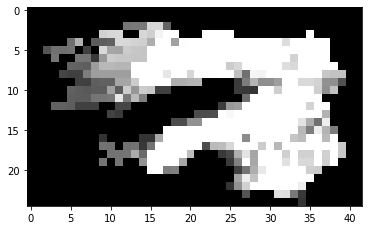

In [7]:
from matplotlib.colors import NoNorm
plt.imshow(example_img, cmap='gray', norm=NoNorm())

<h2>Loading the data</h2>

In [8]:
import glob, os
import re
from datetime import datetime

data_path = "./data"
data_datetime_pattern = re.compile(r'^.*PERSIANN_6h(\d{10}).tif$')

def getDateTimeFromFileName(file_name):
    date_time_string = data_datetime_pattern.search(file_name).group(1)
    return datetime.strptime(date_time_string, '%Y%m%d%H')

def getTiffFileAsArray(file_name):
    return np.asarray(Image.open(file_name))

def getDataWithCoordinates(data_array):
    data_with_coordinates = {}
    for index, value in np.ndenumerate(data_array):
        i, j = index
        y_left_down = YLL_CORNER - CELL_SIZE * (N_ROWS - 1 - i)
        x_left_down = XLL_CORNER + CELL_SIZE * j
        coordinates = {
            'left_down_corner': {'lng': x_left_down, 'lat': y_left_down},
            'left_upper_corner': {'lng': x_left_down, 'lat': y_left_down - CELL_SIZE},
            'right_down_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down},
            'right_upper_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down - CELL_SIZE}
        }
        data_with_coordinates[index] = { 'value': value, 'coordinates': coordinates }
    return data_with_coordinates
        

# get all files containing data
all_files = glob.glob(os.path.join(data_path, '*.tif'), recursive=False)

# load data into array of tuples
data = [(getDateTimeFromFileName(f), getDataWithCoordinates(getTiffFileAsArray(f))) for f in all_files]


In [9]:
# dataWithCoordinates = np.zeros[N_ROWS, N_COLS]
data_with_coordinates = {}

for index, value in np.ndenumerate(data):
    i, j = index
    y_left_down = YLL_CORNER - CELL_SIZE * (N_ROWS - 1 - i)
    x_left_down = XLL_CORNER + CELL_SIZE * j
    coordinates = {
        'left_down_corner': {'lng': x_left_down, 'lat': y_left_down},
        'left_upper_corner': {'lng': x_left_down, 'lat': y_left_down - CELL_SIZE},
        'right_down_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down},
        'right_upper_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down - CELL_SIZE}
    }
    data_with_coordinates[index] = { 'value': value, 'coordinates': coordinates }


# Display data

43.0 14.0
43.0 14.25
43.25 14.0
43.25 14.25


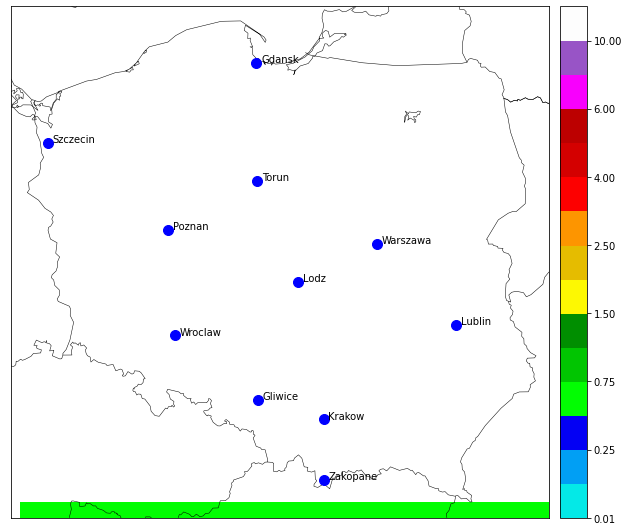

In [72]:
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

cities = {
    'Gdansk': {'pos': (54.36, 18.64)},
    'Gliwice': {'pos': (50.31, 18.67)},
    'Krakow': {'pos': (50.06, 19.96)},
    'Lodz': {'pos': (51.77, 19.46)},
    'Lublin': {'pos': (51.24, 22.57)},
    'Poznan': {'pos': (52.4, 16.9)},
    'Szczecin': {'pos': (53.43, 14.53)},
    'Torun': {'pos': (52.9823, 18.6552)},
    'Wroclaw': {'pos': (51.11, 17.03)},
    'Zakopane': {'pos': (49.29, 19.96)},
    'Warszawa': {'pos': ( 52.2297700, 21.0117800 )},
}

# Colorbar with NSW Precip colors
nws_precip_colors = [
    "#04e9e7",  # 0.01 - 0.10 mm
    "#019ff4",  # 0.10 - 0.25 mm
    "#0300f4",  # 0.25 - 0.50 mm
    "#02fd02",  # 0.50 - 0.75 mm
    "#01c501",  # 0.75 - 1.00 mm
    "#008e00",  # 1.00 - 1.50 mm
    "#fdf802",  # 1.50 - 2.00 mm
    "#e5bc00",  # 2.00 - 2.50 mm
    "#fd9500",  # 2.50 - 3.00 mm
    "#fd0000",  # 3.00 - 4.00 mm
    "#d40000",  # 4.00 - 5.00 mm
    "#bc0000",  # 5.00 - 6.00 mm
    "#f800fd",  # 6.00 - 8.00 mm
    "#9854c6",  # 8.00 - 10.00 mm
    "#fdfdfd"   # 10.00+
]

levels = [
    0.01,
    0.1,
    0.25,
    0.50,
    0.75,
    1.0,
    1.5,
    2.0,
    2.5,
    3.0,
    4.0,
    5.0,
    6.0,
    8.0,
    10.,
    20.0
]

precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

def plot_conus():
    # map max and min lats (Poland)
    lat_min, lat_max = 48.8, 55.0
    lon_min, lon_max = 13.8, 24.4

    # size of result image
    fig = plt.figure(figsize=(10.0, 9.0))

    # margins
    plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10, wspace=0.15, hspace=0.05)
    m = Basemap(
        resolution='i',
        projection='merc',
        llcrnrlat=lat_min,
        urcrnrlat=lat_max,
        llcrnrlon=lon_min,
        urcrnrlon=lon_max)
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    # draw cities
    for name, data in cities.items():
        # coordinates in reversed order
        x, y = m(data['pos'][1], data['pos'][0])

        # drawing a symbol
        m.plot(x, y, 'bo', markersize=10)

        # draw a label with offset
        plt.text(x + 10000, y + 1000, name)
    
    return m

def lat_lon_from_hrap(hrap_x, hrap_y):
    """ Calculate the latitude and longitude for a HRAP grid. """
    raddeg = 57.29577951
    earthrad = 6371.2
    stdlon = 105.
    mesh_len = 4.7625

    tlat = 60. / raddeg
    x = hrap_x - 401.
    y = hrap_y - 1601.
    rr = x * x + y * y
    gi = ((earthrad * (1 + np.sin(tlat))) / mesh_len)
    gi = gi * gi

    ll_y = np.arcsin((gi - rr) / (gi + rr)) * raddeg
    ang = np.arctan2(y, x) * raddeg
    if (ang < 0):
        ang = ang + 360.

    ll_x = 270 + stdlon - ang
    if (ll_x < 0):
        ll_x = ll_x + 360
    if (ll_x > 360):
        ll_x = ll_x - 360
        
    return ll_x, ll_y

def countColumns(input):
    columns = 0
    for key, value in input.items():
        if (key[0] == 0):
            columns += 1
            continue
        break
    
    return columns

def countRows(input):
    rows = 0
    for key, value in input.items():
        if (key[1] == 0):
            rows += 1
            continue
    
    return rows

def getData(input):
    numRows = countRows(input)
    numColumns = countColumns(input)
    
    lats = np.empty((numRows + 1, numColumns + 1), dtype='float')
    longs = np.empty((numRows + 1, numColumns + 1), dtype='float')
    precip_data = np.empty((numRows, numColumns), dtype='float')
    
    for column in range(numColumns):
        for row in range(numRows):
            value = input[(row, column)]['value']
            if value < 0.01:
                value = 0.0
            precip_data[row][column] = 0.5
            
            lats[row + 1][column] = input[(row, column)]['coordinates']['left_upper_corner']['lat']
            longs[row + 1][column] = input[(row, column)]['coordinates']['left_upper_corner']['lng']
            
            lats[row + 1][column + 1] = input[(row, column)]['coordinates']['right_upper_corner']['lat']
            longs[row + 1][column + 1] = input[(row, column)]['coordinates']['right_upper_corner']['lng']
            
            lats[row][column] = input[(row, column)]['coordinates']['left_down_corner']['lat']
            longs[row][column] = input[(row, column)]['coordinates']['left_down_corner']['lng']
            
            lats[row][column + 1] = input[(row, column)]['coordinates']['right_down_corner']['lat']
            longs[row][column + 1] = input[(row, column)]['coordinates']['right_down_corner']['lng']
            
    return lats, longs, precip_data
            
lats, longs, precip_data = getData(data[0][1])

print(lats[0][0], longs[0][0])
print(lats[0][1], longs[0][1])
print(lats[1][0], longs[1][0])
print(lats[1][1], longs[1][1])

# latitude and longitudes of HRAP grid
HRAP_XOR = 14
HRAP_YOR = 10

#for i in range(200):
#    for j in range(200):
#        hrap_x = j + HRAP_XOR + 0.5
#        hrap_y = i + HRAP_YOR + 0.5
#        lon, lat = lat_lon_from_hrap(hrap_x, hrap_y)
#        lats[i, j] = lat
#        longs[i, j] = -lon

m = plot_conus()
norm = matplotlib.colors.BoundaryNorm(levels, 15)
cax = m.pcolormesh(longs, lats, precip_data, latlon=True, norm=norm, cmap=precip_colormap)
m.colorbar(cax)

In [28]:
itemsInRow = 0
for key, value in data[0][1].items():
    if (key[0] == 0):
        itemsInRow += 1
        continue
    break
itemsInRow

42

In [31]:
data[0][1]

{(0, 0): {'value': -99.0,
  'coordinates': {'left_down_corner': {'lng': 14.0, 'lat': 43.0},
   'left_upper_corner': {'lng': 14.0, 'lat': 42.75},
   'right_down_corner': {'lng': 14.25, 'lat': 43.0},
   'right_upper_corner': {'lng': 14.25, 'lat': 42.75}}},
 (0, 1): {'value': -99.0,
  'coordinates': {'left_down_corner': {'lng': 14.25, 'lat': 43.0},
   'left_upper_corner': {'lng': 14.25, 'lat': 42.75},
   'right_down_corner': {'lng': 14.5, 'lat': 43.0},
   'right_upper_corner': {'lng': 14.5, 'lat': 42.75}}},
 (0, 2): {'value': -99.0,
  'coordinates': {'left_down_corner': {'lng': 14.5, 'lat': 43.0},
   'left_upper_corner': {'lng': 14.5, 'lat': 42.75},
   'right_down_corner': {'lng': 14.75, 'lat': 43.0},
   'right_upper_corner': {'lng': 14.75, 'lat': 42.75}}},
 (0, 3): {'value': -99.0,
  'coordinates': {'left_down_corner': {'lng': 14.75, 'lat': 43.0},
   'left_upper_corner': {'lng': 14.75, 'lat': 42.75},
   'right_down_corner': {'lng': 15.0, 'lat': 43.0},
   'right_upper_corner': {'lng': 15.

(120, 41)
(121, 42)
(121, 42)


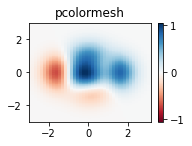

In [53]:
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

plt.subplot(2, 2, 2)
plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.title('pcolormesh')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()

print(z.shape)
print(x.shape)
print(y.shape)